# Построение mel-спектрограммы

## Читаем аудиосигнал

In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

filename = 'audio_input_4.wav'
signal, fs = sf.read(filename)

Посмотрим на число каналов

In [2]:
print(signal.ndim)

2


In [3]:
if signal.ndim > 1:
    signal = signal[:, 0]

Применим pre‑emphasis

In [4]:
def get_emphasis(signal, alpha=0.97):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

In [5]:
def hz_to_mel(f):
    return 2595.0 * np.log10(1 + f / 700.0)

def mel_to_hz(m):
    return 700.0 * (10**(m / 2595.0) - 1)

## Вычисление mel-спектограммы(окно Ханна + шкала mel)

In [6]:
def compute_mel_spectrogram(signal, fs, frame_length_ms=25, frame_step_ms=10, M=80, fmin=20.0):
    emphasized = get_emphasis(signal)
    frame_length_ms = frame_length_ms
    frame_step_ms = frame_step_ms

    # Переводим ms в количество сэмплов
    L = int(frame_length_ms * fs * 10**-3)
    H = int(frame_step_ms * fs * 10**-3)

    # Считаем кол-во окон
    num_frames = int((len(emphasized) - L) / H)
    window = np.hanning(L)

    # БПФ
    NFFT = 2** int(np.log2(L))
    K = NFFT // 2

    power_spectr = np.zeros((num_frames, K + 1))
    for i in range(num_frames):
        start = i * H
        frame = emphasized[start:start + L]
        frame_window = frame * window
        spectr = np.fft.rfft(frame_window, n=NFFT)
        power = (np.abs(spectr) ** 2) / NFFT
        power_spectr[i, :] = power

    fmax = fs / 2.0

    mel_min = hz_to_mel(fmin)
    mel_max = hz_to_mel(fmax)
    mel_points = np.linspace(mel_min, mel_max, M + 2)
    hz_points = mel_to_hz(mel_points)

    arr_freq = np.linspace(0, fs / 2, K + 1)

    filter_save = np.zeros((M, K + 1))
    for m in range(1, M + 1):
        f_left, f_center, f_right = hz_points[m - 1], hz_points[m], hz_points[m + 1]
        left = (arr_freq >= f_left) & (arr_freq <= f_center)
        right = (arr_freq >= f_center) & (arr_freq <= f_right)
        filter_save[m - 1, left] = (arr_freq[left] - f_left) / (f_center - f_left)
        filter_save[m - 1, right] = (f_right - arr_freq[right]) / (f_right - f_center)

    mel_energy = filter_save.dot(power_spectr.T)
    return mel_energy


## Визуальзация mel-спектограммы

In [7]:
def plot_mel_spectrogram(mel_energy, title='mel-спектрограмма'):
    plt.figure(figsize=(8, 4))
    plt.imshow(mel_energy, origin='lower', aspect='auto', interpolation='nearest')
    plt.xlabel('Фрейм')
    plt.ylabel('Mel-полоса')
    plt.title(title)
    plt.colorbar(label='Энергия')
    plt.show()

## Добавление шума(чтобы точно его наблюдать)

In [8]:
def add_noise(signal, snr_db):
    snr_linear = 10 ** (snr_db / 10.0)
    signal_power = np.mean(signal ** 2)
    noise = np.random.randn(*signal.shape)
    noise_power = np.mean(noise ** 2)
    factor = np.sqrt(signal_power / (snr_linear * noise_power))
    return signal + noise * factor

## Шумоподавление с использованием IRM

In [9]:
def ideal_ratio_mask_denoise(clean_signal, noisy_signal, fs, frame_length_ms=25, frame_step_ms=10):
    L = int(frame_length_ms * fs * 1e-3)
    H = int(frame_step_ms * fs * 1e-3)
    NFFT = 2 ** int(np.ceil(np.log2(L)))
    window = np.hanning(L)
    num_frames = int(np.ceil((len(noisy_signal) - L) / H))
    output = np.zeros(num_frames * H + L)
    normalization = np.zeros_like(output)
    eps = 1e-10
    
    for i in range(num_frames):
        start = i * H
        frame_noisy = noisy_signal[start:start + L]
        frame_clean = clean_signal[start:start + L]
        if len(frame_noisy) < L:
            frame_noisy = np.pad(frame_noisy, (0, L - len(frame_noisy)))
            frame_clean = np.pad(frame_clean, (0, L - len(frame_clean)))
        stft_noisy = np.fft.rfft(frame_noisy * window, n=NFFT)
        stft_clean = np.fft.rfft(frame_clean * window, n=NFFT)
        noise_spec = stft_noisy - stft_clean
        mask = np.abs(stft_clean) / (np.abs(stft_clean) + np.abs(noise_spec) + eps)
        new_magnitude = mask * np.abs(stft_noisy)
        stft_denoised = new_magnitude * np.exp(1j * np.angle(stft_noisy))
        frame_denoised = np.fft.irfft(stft_denoised, n=NFFT)[:L]
        output[start:start + L] += frame_denoised * window
        normalization[start:start + L] += window ** 2
        
    denoised = np.zeros_like(output)
    nz = normalization > eps
    denoised[nz] = output[nz] / normalization[nz]
    return denoised[:len(noisy_signal)]


## Метрики

In [10]:
def snr_metric(clean, noise):
    error = clean - noise
    return 10 * np.log10(np.sum(clean ** 2) / (np.sum(error ** 2) + 1e-10))

def si_sdr_metric(clean, noise):
    clean = clean - np.mean(clean)
    noise = noise - np.mean(noise)
    s_target = (np.dot(noise, clean) / (np.dot(clean, clean) + 1e-10)) * clean
    e_noise = noise - s_target
    ratio = np.sum(s_target ** 2) / (np.sum(e_noise ** 2) + 1e-10)
    return 10 * np.log10(ratio + 1e-10)

def mse_time_domain(clean, noise):
    min_len = min(len(clean), len(noise))
    clean = clean[:min_len]
    noise = noise[:min_len]
    return np.mean((clean - noise) ** 2)    


## Измерения

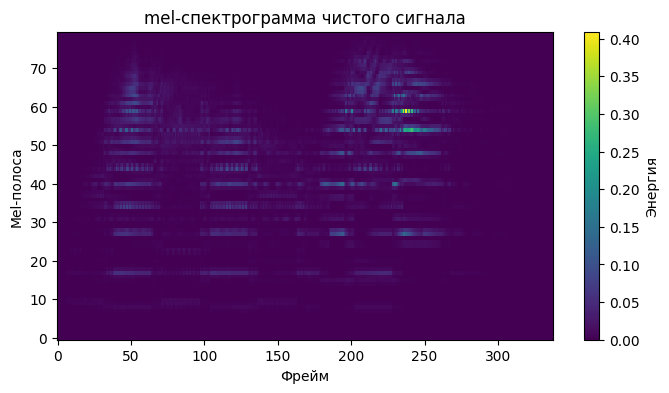

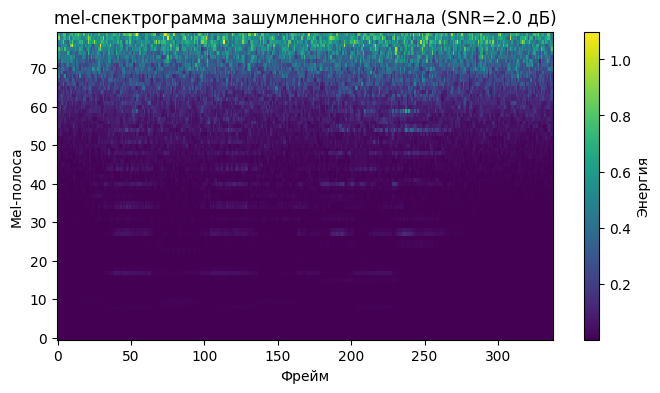

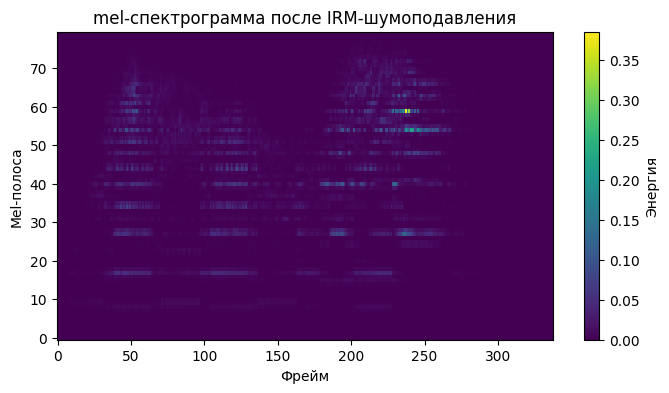

Метрики качества:
  SNR до шумоподавления:    2.00 дБ
  SNR после шумоподавления: 5.10 дБ
  SI-SDR до:                 1.98 дБ
  SI-SDR после:              4.22 дБ
  MSE во времени (до):    0.0187
  MSE во времени (после): 0.0092


In [11]:
# чистый сигнал
mel_clean = compute_mel_spectrogram(signal, fs)
plot_mel_spectrogram(mel_clean, title='mel-спектрограмма чистого сигнала')

# с добавлением шума
snr_db = 2.0
noisy_signal = add_noise(signal, snr_db)
mel_noisy = compute_mel_spectrogram(noisy_signal, fs)
plot_mel_spectrogram(mel_noisy, title=f'mel-спектрограмма зашумленного сигнала (SNR={snr_db} дБ)')

# с использованием шумаподавления
clean_signal = signal.copy()
denoised_signal = ideal_ratio_mask_denoise(clean_signal, noisy_signal, fs)
mel_denoised = compute_mel_spectrogram(denoised_signal, fs)
plot_mel_spectrogram(mel_denoised, title='mel-спектрограмма после IRM-шумоподавления')

snr_before = snr_metric(signal, noisy_signal)
snr_after = snr_metric(signal, denoised_signal)
si_sdr_before = si_sdr_metric(signal, noisy_signal)
si_sdr_after = si_sdr_metric(signal, denoised_signal)
mse_before = mse_time_domain(signal, noisy_signal)
mse_after = mse_time_domain(signal, denoised_signal)


print('Метрики качества:')
print(f'  SNR до шумоподавления:    {snr_before:.2f} дБ')
print(f'  SNR после шумоподавления: {snr_after:.2f} дБ')
print(f'  SI-SDR до:                 {si_sdr_before:.2f} дБ')
print(f'  SI-SDR после:              {si_sdr_after:.2f} дБ')
print(f'  MSE во времени (до):    {mse_before:.4f}')
print(f'  MSE во времени (после): {mse_after:.4f}')


## Вывод
Алгоритм шумоподавления на основе IRM показывает хорошее улучшение качества речи:  
SNR вырос с $2.00$ до $5.10$ дБ, SI-SDR — с $1.98$ до $4.22$ дБ, а ошибка во времени (MSE) уменьшилась почти в два раза.  
Можно сделать вывод, что восстановленный сигнал стал заметно ближе к чистому как по энергии, так и по форме волны.